# Gathering data

In [ ]:
import os
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

RAV = '/content/drive/MyDrive/Vision_Project/audio_speech_actors_01-24/'

Mounted at /content/drive


In [ ]:
dir_list = os.listdir(RAV)

emotion = []
gender = []
path = []
feature = []
for i in dir_list:
    fname = os.listdir(RAV + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAV + i + '/' + f)

RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender),RAV_df],axis=1)
RAV_df.columns = ['gender','emotion']
RAV_df['labels'] =RAV_df.gender + '_' + RAV_df.emotion
RAV_df['source'] = 'RAVDESS'
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAV_df = RAV_df.drop(['gender'], axis=1)

RAV_df.tail()

,emotion,labels,source,path
1435,disgust,male_disgust,RAVDESS,/content/drive/MyDrive/Vision_Project/audio_sp...
1436,surprise,male_surprise,RAVDESS,/content/drive/MyDrive/Vision_Project/audio_sp...
1437,surprise,male_surprise,RAVDESS,/content/drive/MyDrive/Vision_Project/audio_sp...
1438,disgust,male_disgust,RAVDESS,/content/drive/MyDrive/Vision_Project/audio_sp...
1439,disgust,male_disgust,RAVDESS,/content/drive/MyDrive/Vision_Project/audio_sp...


# Preprocess

The following steps will be followed to preprocess the audio:

1. Get an array of samples
2. Trim the silence  
3. Padding for equal length

In [ ]:
!pip install pydub
from pydub import AudioSegment, effects

In [ ]:
def preprocess_audio(path):
    _, sr = librosa.load(path)
    raw_audio = AudioSegment.from_file(path)

    samples = np.array(raw_audio.get_array_of_samples(), dtype='float32')
    trimmed, _ = librosa.effects.trim(samples, top_db=25)
    padded = np.pad(trimmed, (0, 180000-len(trimmed)), 'constant')
    return padded, sr

In [ ]:
emotion_dic = {
    'neutral' : 0,
    'happy'   : 1,
    'sad'     : 2,
    'angry'   : 3,
    'fear'    : 4,
    'disgust' : 5,
    'surprise': 6
}

def encode(label):
    return emotion_dic.get(label)

# Extract features

We will only extract these features:

1. Mel-Frequency Cepstral Coefficients: captures the shape of the spectral envelope of a signal
2. Zero Crossing Rate: captures the number of times a signal changes sign per second
3. Root Mean Square Energy: captures the root mean square amplitude of the audio signal

In [ ]:
zcr_list = []
rms_list = []
mfccs_list = []
emotion_list = []

FRAME_LENGTH = 2048
HOP_LENGTH = 512

for row in RAV_df.itertuples(index=False):
    try:
        y, sr = preprocess_audio(row.path)

        zcr = librosa.feature.zero_crossing_rate(y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        rms = librosa.feature.rms(y=y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=HOP_LENGTH)

        zcr_list.append(zcr)
        rms_list.append(rms)
        mfccs_list.append(mfccs)

        emotion_list.append(encode(row.emotion))
    except:
        print(f"Failed for path: {row.path}")

Failed for path: /content/drive/MyDrive/Vision_Project/audio_speech_actors_01-24/Actor_20/03-01-06-01-01-02-20.wav
Failed for path: /content/drive/MyDrive/Vision_Project/audio_speech_actors_01-24/Actor_05/03-01-02-01-02-02-05.wav


In [ ]:
print(len(zcr_list))
print(len(rms_list))
print(len(mfccs_list))
print(len(emotion_list))

1438
1438
1438
1438


In [ ]:
X = np.concatenate((
    np.swapaxes(zcr_list, 1, 2),
    np.swapaxes(rms_list, 1, 2),
    np.swapaxes(mfccs_list, 1, 2)),
    axis=2
)
X = X.astype('float32')

y = np.asarray(emotion_list)
y = np.expand_dims(y, axis=1).astype('int8')

In [ ]:
print(X.shape)
print(y.shape)

(1438, 352, 15)
(1438, 1)


# Build a LSTM


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [ ]:
X_train, X_to_split, y_train, y_to_split = train_test_split(X, y, test_size=0.12, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_to_split, y_to_split, test_size=0.3, random_state=1)

y_train_class = to_categorical(y_train, 7)
y_val_class = to_categorical(y_val, 7)


In [ ]:
y_test_class = to_categorical(y_test, 7)

In [ ]:
from keras.models import Sequential
from keras import layers, optimizers, callbacks
from tensorflow.keras.optimizers import Adam

In [ ]:
MODEL = Sequential()
MODEL.add(layers.LSTM(64, return_sequences=True, input_shape=(X.shape[1:3])))
MODEL.add(layers.LSTM(64))
MODEL.add(layers.Dense(7, activation='softmax'))

In [22]:
rlrop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.01, patience=100)
MODEL.compile(loss='categorical_crossentropy', optimizer='RMSProp', metrics=['categorical_accuracy'])
model = MODEL.fit(X_train, y_train_class, epochs=200, batch_size=6, validation_data=(X_val, y_val_class))

Epoch 1/200
211/211 [==============================] - 125s 487ms/step - loss: 1.7037 - categorical_accuracy: 0.3146 - val_loss: 1.6356 - val_categorical_accuracy: 0.3388
Epoch 2/200
211/211 [==============================] - 70s 331ms/step - loss: 1.5779 - categorical_accuracy: 0.4000 - val_loss: 1.5423 - val_categorical_accuracy: 0.4050
Epoch 3/200
211/211 [==============================] - 85s 404ms/step - loss: 1.5384 - categorical_accuracy: 0.4103 - val_loss: 1.4908 - val_categorical_accuracy: 0.4215
Epoch 4/200
211/211 [==============================] - 75s 357ms/step - loss: 1.4832 - categorical_accuracy: 0.4427 - val_loss: 1.4811 - val_categorical_accuracy: 0.4132
Epoch 5/200
211/211 [==============================] - 72s 343ms/step - loss: 1.5132 - categorical_accuracy: 0.4206 - val_loss: 1.6195 - val_categorical_accuracy: 0.3967
Epoch 6/200
211/211 [==============================] - 74s 350ms/step - loss: 1.4941 - categorical_accuracy: 0.4229 - val_loss: 1.5698 - val_categori

# Evaluate and conclude

In [23]:
from sklearn.metrics import confusion_matrix

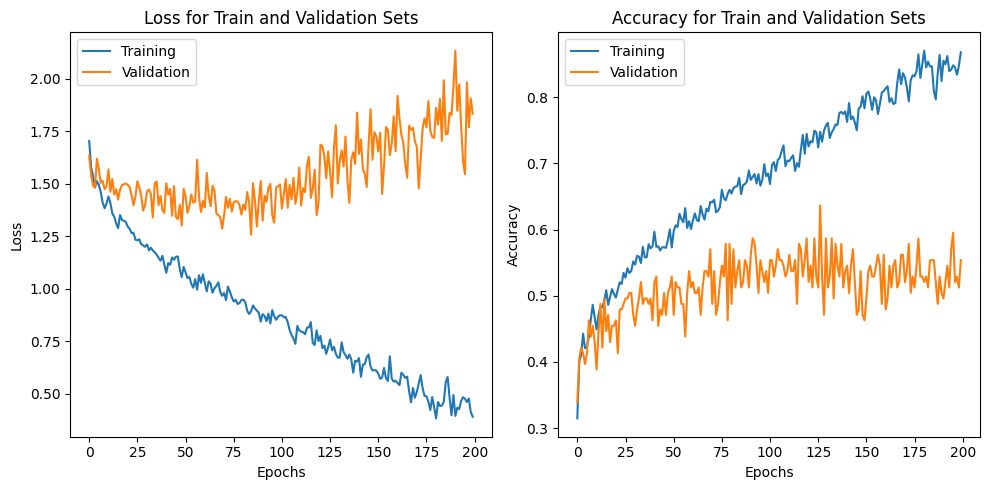

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(model.history['loss'])
axes[0].plot(model.history['val_loss'])
axes[0].set_title('Loss for Train and Validation Sets')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epochs')
axes[0].legend(['Training', 'Validation'])

axes[1].plot(model.history['categorical_accuracy'])
axes[1].plot(model.history['val_categorical_accuracy'])
axes[1].set_title('Accuracy for Train and Validation Sets')
axes[1].set_ylabel('Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].legend(['Training', 'Validation'])

fig.tight_layout()

plt.show()

4/4 [==============================] - 4s 255ms/step


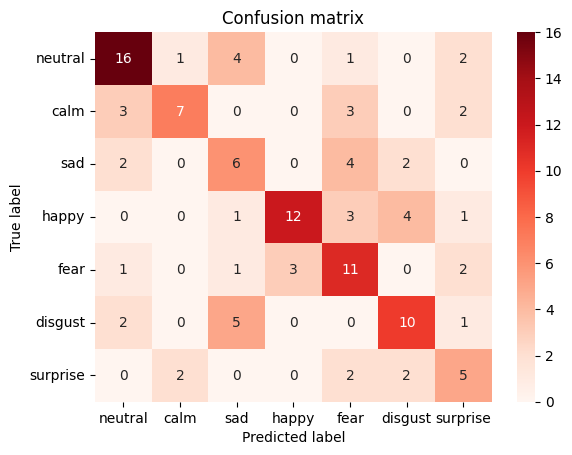

In [25]:
import seaborn as sns

y_pred = np.argmax(MODEL.predict(X_val), axis=1)
labels = ['neutral', 'calm', 'sad', 'happy', 'fear', 'disgust', 'surprise']
cm = confusion_matrix(np.argmax(y_val_class, axis=1), y_pred, labels=range(7))

sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

In [26]:
MODEL.evaluate(X_test, y_test_class)[1]*100

2/2 [==============================] - 0s 132ms/step - loss: 1.9587 - categorical_accuracy: 0.5577


55.7692289352417